# **Anàlisi de les certificacions**

L'Institut Ramon Llull organitza proves per a l'avaluació i la certificació de coneixements de català com a llengua estrangera fora del domini lingüístic. Les dades sobre aquestes proves es troben contingudes dins del conjunt de dades "certificacions" el qual es vol analitzar. Així doncs, en aquest primer script es poden descobrir els passos realitzats per a l'exploració i neteja d'aquest conjunt de dades prenent com a base les llibreries Numpy i Pandas.

## Imports i includes

Primer de tot, s'importen i s'instal·len tots els paquets i llibreries necessaris per al correcte desenvolupament de tot el projecte

In [ ]:
pip install openpyxl --upgrade --pre

In [ ]:
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import time
import difflib
import re
import datetime
from collections import Counter

## Exploració i neteja de dades

A continuació, es llegeixen les dades directament extretes de la base de dades de l'Institut Ramon Llull:

In [ ]:
Dades = files.upload()   # Importem el fitxer

dd = pd.read_excel(io.BytesIO(Dades['certificacio.xlsx']))  # Llegim el fitxer en format .xlsx

Saving certificacio.xlsx to certificacio.xlsx


Es comprova que les dades s'hagin carregat correctament així com s'observa la visió general del conjunt de dades:

In [ ]:
dd.head()

,id_examen,informe_avaluacio,certificat_mobilitat_creat,preu,import_pagat,data_pagament,presentat,resultat,canvi_pendent,id_conv_seus_nivells,...,hores_catala_alumne,motiu_prova_alumne,centre_catala_ultim_any,uni_catala_ultim_any,id_pais_alumnes,pais_alumne,num_pais_alumne,irpf1_pais_alumne,irpf2_pais_alumne,ambit_alumne
0,3070,0,0,30,30,2011-03-20 12:11:47,1,1,0,1060,...,NaN,NaN,NaN,NaN,74,França,7.0,19,0,5
1,3466,0,0,30,30,2011-04-06 19:10:31,1,1,0,1060,...,NaN,ES,NaN,NaN,74,França,7.0,19,0,5
2,4130,0,0,30,30,2011-04-28 11:08:12,1,1,0,1060,...,1960-01-01 00:00:00,IN,NaN,NaN,74,França,7.0,19,0,5
3,10657,0,0,0,0,NaT,1,1,0,5478,...,1960-01-01 00:00:00,NaN,NaN,NaN,74,França,7.0,19,0,5
4,10723,0,0,0,0,NaT,1,1,0,5478,...,60-120,NaN,NaN,NaN,74,França,7.0,19,0,5


S'obté informació de amb quantes tuples i variables s'està tractant així com el seu tipus:

In [ ]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19762 entries, 0 to 19761
Data columns (total 66 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id_examen                                     19762 non-null  int64         
 1   informe_avaluacio                             19762 non-null  int64         
 2   certificat_mobilitat_creat                    19762 non-null  int64         
 3   preu                                          19762 non-null  int64         
 4   import_pagat                                  19762 non-null  int64         
 5   data_pagament                                 8816 non-null   datetime64[ns]
 6   presentat                                     19762 non-null  int64         
 7   resultat                                      19762 non-null  int64         
 8   canvi_pendent                                 19762 non-null  int6

In [ ]:
#Linia de codi introduida per evitar el warning fals positiu que retorna al realitzar indexacions
pd.options.mode.chained_assignment = None  # default='warn'

Es nota que la variable data_naixement_alumne s'ha detectat incorrectament com a object en comptes de com a data. A continuació es canvia el tipus per a poder realitzar els següents anàlisis sense altre problema

In [ ]:
dd.loc[dd['data_naixement_alumne'] == "0000-00-00", 'data_naixement_alumne'] = np.nan

In [ ]:
dd['data_naixement_alumne'] = pd.to_datetime(dd['data_naixement_alumne'])

A partir d'aquí es comença a dur a terme l'exploració de les dades així com la seva neteja si aquestes ho requereixen:

### Pas 1: Eliminar observacions irrellevants o duplicades

Per a saber si hi ha observacions irrellevants, s'ha de saber si hi ha alguna tupla on la gran majoria de columnes siguin nul·les.

Per a fer-ho, es detecta si hi ha algun cas on la gran majoria d'IDs o variables importants que fan referència de forma directa a la inscripció de l'examen o a quelcom relacionat amb aquest són nul·les.

In [ ]:
for id in ['id_examen', 'id_nivell', 'id_conv_seus', 'id_convocatoria', 'id_conv_seus_nivells', 'id_seus', 'id_pais', 'id_alumnes']:
  print('Nombre de NaNs a', id, ': ', dd[id].isnull().sum())

Nombre de NaNs a id_examen :  0
Nombre de NaNs a id_nivell :  0
Nombre de NaNs a id_conv_seus :  0
Nombre de NaNs a id_convocatoria :  0
Nombre de NaNs a id_conv_seus_nivells :  0
Nombre de NaNs a id_seus :  0
Nombre de NaNs a id_pais :  0
Nombre de NaNs a id_alumnes :  0


Totes les tuples tenen les variables més importants del conjunt de dades indicades i, per tant, es pot continuar amb l'anàlisi sense cap problema.

Tot seguit es comprova que no existeix cap tupla "repetida", és a dir, que tingui el mateix
1. id_alumnes
2. id_convocatoria 
3. id_nivell (ja que un usuari es pot presentar a múltiples nivells dins d'una convocatòria)

Si existeix alguna tupla que trenca la restricció s'esborrarà la més antiga (dins les repetides), al ser generalment la que conté menys informació.

In [ ]:
duplicades = dd.duplicated(['id_alumnes', 'id_convocatoria', 'id_nivell'], keep = False)
print(len(dd[duplicades]))

26


In [ ]:
dd = dd.drop_duplicates(subset = ['id_alumnes', 'id_convocatoria', 'id_nivell'], keep = 'last')

### Pas 2: Tractar amb els Nans 

Els nuls es poden imputar, deixar-los si se sap que no produiran cap efecte sobre l'anàlisi o eliminar les tuples o columnes que els continguin. En aquest cas, només s'analitzarà el percentatge de nuls per columna i per tant aquestes seran directament eliminades si:


1.   Més del 75% de les files són nul·les
2.   Se sap que no es poden imputar a partir d'altres columnes
3.   No aporten informació particularment rellevant

Normalment és un pas que es faria més tard, tanmateix, es realitza abans perquè així es poden descobrir vàries columnes que s'eliminaran i que, per tant, no caldrà analitzar a posteriori.

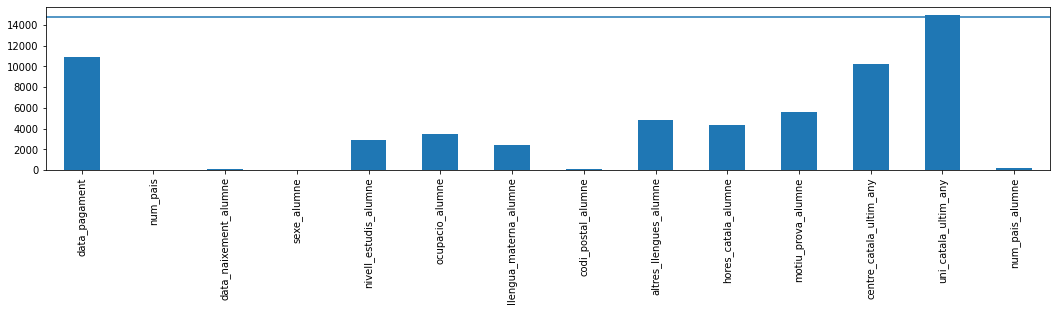

In [ ]:
dd.isna().sum()[dd.isna().sum()>0].plot(kind='bar', figsize=(18, 3))
plt.axhline(dd.shape[0]*0.75) #introduim una linia horitzontal a la gràfica que ens facilita visualitzar
                              #les columnes amb més d'un 75% de nulls

Només la variable uni_catala_ultim_any conté un nombre excessiu de nuls. Tanmateix, és precisament una de les variables que es vol analitzar i, per tant, es mantindrà en el conjunt de dades saben en tot moment que les estadístiques obtingudes a partir d'aquesta variable no seran 100% fiables.


### Pas 3: Arreglar errors d'escriptura observats a texts (objectes) i dates

Durant aquesta secció es pretén resoldre aquells problemes de codificació múltiple (múltiples cadenes de text volent dir el mateix), comprovar els formats de les dates i recodificar objectes massa llargs si és necessari, entre d'altres.

Per a fer-ho, primer de tot es creen 3 grups de variables segons si són textos (o objectes), dates o números (analitzats en la secció 4):

In [ ]:
#Creem tres grups de variables segons si són strings, dates o números 
numeros = []
strings = []
dates = []
for col_name in dd.columns:
  if dd[col_name].dtypes == np.float64 or dd[col_name].dtypes == np.int64:
    numeros.append(col_name)
  elif dd[col_name].dtypes == 'object':
    strings.append(col_name)
  else: 
    dates.append(col_name)
print(numeros)
print(strings)
print(dates)

['id_examen', 'informe_avaluacio', 'certificat_mobilitat_creat', 'preu', 'import_pagat', 'presentat', 'resultat', 'canvi_pendent', 'id_conv_seus_nivells', 'actiu_conv_seus_nivells', 'preu_conv_seus_nivells', 'sequencial_conv_seus_nivells', 'id_nivell', 'preu_nivell', 'num_clausus_nivell', 'id_conv_seus', 'format_electronic_conv_seus', 'enregistradora_conv_seus', 'id_convocatoria', 'any_convocatoria', 'codi_convocatoria', 'actiu_convocatoria', 'pagament_transferencia_actiu_convocatoria', 'descarrega_proves_activa_convocatoria', 'certificat_mobilitat_actiu_convocatoria', 'id_seus', 'codi_seus', 'gratuita_seus', 'id_pais', 'num_pais', 'irpf1_pais', 'irpf2_pais', 'id_alumnes', 'id_pais_alumnes', 'num_pais_alumne', 'irpf1_pais_alumne', 'irpf2_pais_alumne', 'ambit_alumne']
['nivell', 'codi_nivell', 'institucio_examen_conv_seus', 'poblacio_examen_conv_seus', 'nom_convocatoria', 'nom_seus', 'sigles_seus', 'pais', 'sexe_alumne', 'inscripcio_previa_cert_alumne', 'nivell_estudis_alumne', 'ocupaci

#### Pas 3.1: Dates

D'una banda es comprova que les dates es troben entre el 2003 i 2022 que són els anys durant els quals l'IRL ha realitzat exàmens de certificació.

S'introdueix un cas especial de comprovació per a data_naixement_alumne. En aquest cas s'ha de saber que pot dur a terme l'examen tota persona que tingui més de catorze anys. A més a més, també es comprovarà que l'usuari tingui menys de noranta-cinc anys en considerar-se una edat a partir de la qual una persona ja no faria un examen d'aquest tipus.

In [ ]:
data_minima = pd.Timestamp("2003-1-1")
data_maxima = pd.Timestamp("2022-12-31")
data_max_naixement = datetime.datetime.now() - datetime.timedelta(days=14*365) # Has de tenir mínim 14 anys a l'hora de fer la prova
data_min_naixement = datetime.datetime.now() - datetime.timedelta(days=95*365) #Assumint que no es realitzen examens amb més de 95 anys
for col_name in dates:
  if col_name == 'data_naixement_alumne': #No cal fer un else perquè és la última variable de "dates"
    data_minima = data_min_naixement
    data_maxima = data_max_naixement
  print('\033[1m', col_name,':\033[0m', 'minima', np.sum(dd[col_name] < data_minima), '---------', 'maxima', np.sum(dd[col_name] > data_maxima))

 data_pagament : minima 0 --------- maxima 0
 data_obertura_liquidacio_convocatoria : minima 0 --------- maxima 0
 data_tancament_liquidacio_convocatoria : minima 0 --------- maxima 0
 data_examen : minima 0 --------- maxima 0
 data_consulta_resultats_examens_convocatoria : minima 0 --------- maxima 0
 data_obertura_inscripcio_convocatoria : minima 0 --------- maxima 0
 data_tancament_inscripcio_convocatoria : minima 0 --------- maxima 0
 data_naixement_alumne : minima 17 --------- maxima 306


Les dates que no es troben dins del rang especificat es consideren incorrectes i seran canviades a nul al no poder imputar la data de naixement dels candidats.

In [ ]:
dd.loc[dd['data_naixement_alumne'] < data_min_naixement, 'data_naixement_alumne'] = np.nan
dd.loc[dd['data_naixement_alumne'] > data_max_naixement, 'data_naixement_alumne'] = np.nan

#### Pas 3.2: Objectes (text)

D'altra banda, a continuació es confirma que els textos no tinguin errors d'escriptura. Aquells que tenen poques opcions es comproven visualment, mentre en els altres casos es realitzaran tècniques més avançades

In [ ]:
falta_revisar_strings = []
for col_name in strings:
  uniq = pd.unique(dd[col_name])
  if len(uniq) < 40: 
    print('\033[1m', col_name,':\033[0m', uniq)
  else:
    falta_revisar_strings.append(col_name)

 nivell : ['Bàsic' 'Elemental' 'Suficiència' 'Intermedi' 'Superior']
 codi_nivell : ['A2' 'B1' 'C1' 'B2' 'C2']
 nom_convocatoria : ['1a convocatòria 2011' '1a convocatòria 2007' '1a convocatòria 2006'
 '1a convocatòria 2016' '1a convocatòria 2017' '1a convocatòria 2019'
 '1a convocatòria 2021' '1a convocatòria 2008' '1a convocatòria 2009'
 '1a convocatòria 2010' '1a convocatòria 2012' '1a convocatòria 2013'
 '1a convocatòria 2005' '1a convocatòria 2004' '1a convocatòria 2014'
 '1a convocatòria 2015' '1a convocatòria 2018' '1a convocatòria 2020'
 '2a convocatòria 2010' '2a convocatòria 2011' '2a convocatòria 2012'
 '2a convocatòria 2008' '2a convocatòria 2007' '2a convocatòria 2014'
 '2a convocatòria 2015' '2a convocatòria 2016' '2a convocatòria 2017'
 '2a convocatòria 2018' '2a convocatòria 2019' '2a convocatòria 2021'
 '1a convocatòria 2003' '2a convocatòria 2009' '2a convocatòria 2013'
 '2a convocatòria 2006' '2a convocatòria 2005']
 sexe_alumne : ['F' 'M' nan]
 inscripcio_previa_cer

D'una banda es nota que la data "datetime.datetime(1960, 1, 1, 0, 0)" que hi ha al camp hores_catala_alumne és clarament incorrecte i, per tant, a continuació es canviarà a nul:

In [ ]:
data_inc = dd['hores_catala_alumne'] == datetime.datetime(1960, 1, 1, 0, 0)
print(sum(data_inc))
dd.loc[data_inc, 'hores_catala_alumne'] = np.nan

4124


En veure que tantes tuples prenien aquest valor, es decideix tornar a calcular el percentatge de valors nuls per aquesta variable:

In [ ]:
llarg_dataset = len(dd)
print(np.round(np.sum(pd.isna(dd['hores_catala_alumne']))/llarg_dataset*100, 2), "% de nulls")

43.1 % de nulls


Aquest ha augmentat bastant, però continua sent un número raonable i, per tant, la variable es continuarà mantenint dins del conjunt de dades.


Tot seguit, es nota que la variable centre_catala_ultim_any pren un valor "Quito" que no és correcte i, per tant, es recodificarà a "Altres".

In [ ]:
quito = dd['centre_catala_ultim_any'] == "Quito"
print(sum(quito)) #Només passa 1 cop 
dd.loc[quito, 'centre_catala_ultim_any'] = "Altres"

1


Així doncs, falta revisar les següents variables:

In [ ]:
falta_revisar_strings

['institucio_examen_conv_seus',
 'poblacio_examen_conv_seus',
 'nom_seus',
 'sigles_seus',
 'pais',
 'ocupacio_alumne',
 'llengua_materna_alumne',
 'codi_postal_alumne',
 'altres_llengues_alumne',
 'uni_catala_ultim_any',
 'pais_alumne']

Primerament, se sap que les variables nom_seus, sigles_seus, pais i pais_alumne són completament correctes gràcies a l'origen de la base de dades i, per tant, no es realitzarà cap preprocès sobre aquestes, podent-les eliminar de la llista de variables a analitzar.


En segon lloc, s'analitzaran les variables institucio_examen_conv_seus i poblacio_examen_conv_seus. En nota que aquestes dues variables contenen un elevat nombre de tuples amb una 'a'. En veure que és un error, ja que el camp s'hauria de trobar omplert en tot moment en ser responsabilitat dels propis usuaris de l'IRL, es comenta amb l'àrea. Des de aquesta s'envia un Excel fet pels usuaris interns de l'IRL que conté la correspondència de cada convocatòria amb la població, institució i a més a més una nova variable "Seu", que indica el tipus d'institució i que també es vol analitzar.

A continuació s'importa aquest Excel i es modifiquen les dues variables perquè prenguin el valor correcte en tot moment així com es crea la nova variable mencionada sota el nom "tipus_institucio".

Es modifiquen totes les tuples, no només les que mostren una 'a', perquè sobre aquest Excel també s'ha realitzat una uniformització dels noms de les institucions de forma semimanual així com s'han canviat tots els noms al català, aquests passos ja fets per mi. A més a més, se li ha afegit l'id_conv_seu per a permetre el procés d'unificació dels dos conjunts de dades fàcilment.

In [ ]:
Dades = files.upload()   # Importem el fitxer

dd_institucions = pd.read_excel(io.BytesIO(Dades['Seus examen.xlsx']))  # Llegim el fitxer en format .xlsx

Saving Seus examen.xlsx to Seus examen.xlsx


In [ ]:
dd_institucions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_conv_seu       1547 non-null   int64 
 1   convocatoria_nom  1547 non-null   object
 2   localitat         1547 non-null   object
 3   nom_institucio    1547 non-null   object
 4   seu               1546 non-null   object
 5   pais              1547 non-null   object
dtypes: int64(1), object(5)
memory usage: 72.6+ KB


In [ ]:
# Creació de la variable tipus_institucio
dd['tipus_institucio'] = 'tipus_institucio'

#Realitzem els canvis de les tres variable
for i in dd_institucions.index: #Per totes les files de dd_institucions
  conv_seus = dd['id_conv_seus'] == dd_institucions["id_conv_seu"][i] #busquem les files del conjunt de dades inicials que fan referència a la mateixa convocatòria i seu
  dd.loc[conv_seus, 'institucio_examen_conv_seus'] = dd_institucions["nom_institucio"][i]
  dd.loc[conv_seus, 'poblacio_examen_conv_seus'] = dd_institucions["localitat"][i]
  dd.loc[conv_seus, 'tipus_institucio'] = dd_institucions["seu"][i]

Un cop realitzat el procés explicat prèviament es passa a analitzar la variable ocupacio_alumne. Aquesta variable és agafada directament d'un camp de text lliure d'un formulari. Això dona lloc a múltiples variacions d'un mateix treball així com a múltiples ocupacions diferents. Com que és impossible uniformitzar-los tots un per un, s'unifiquen només les ocupacions més realitzades.

Per a fer-ho, es crea un llista amb totes les paraules que surten en aquesta columna. Després, es compten el nombre de cops que surt cadascuna quedant-se amb les 80 paraules més repetides (assumint que no totes seran realment "ocupacions" i que varies d'elles voldran dir el mateix). Posteriorment, de les 80 paraules es realitzen grups amb les ocupacions i es van buscant a cada fila substituint el text actual per una d'aquestes ocupacions o nul.

In [ ]:
#Creem la llista amb totes les paraules de la columna:
dd["ocupacio_alumne"]=dd["ocupacio_alumne"].astype(str) #convertim tots els elements de la columna a strings
ocupacions = ' '.join(dd["ocupacio_alumne"]) #concatenem tota la columna en 1 sol string
ocupacions = ocupacions.split() #dividim l'string per paraules
#trobem les 80 paraules més comunes
Count = Counter(ocupacions)
ocupacions = Count.most_common(80)
#ocupacions

In [ ]:
#realizem les substitucions del text actual per les noves categories
dd.loc[dd['ocupacio_alumne'].str.contains("Estudiant|universitari|Student", case=False), 'ocupacio_alumne'] = "Estudiant"
dd.loc[dd['ocupacio_alumne'].str.contains("Professor|Profesor|Mestr|Docent|Maestra|Educador", case=False), 'ocupacio_alumne'] = "Professor"
dd.loc[dd['ocupacio_alumne'].str.contains("Administrat", case=False), 'ocupacio_alumne'] = "Administratiu"
dd.loc[dd['ocupacio_alumne'].str.contains("Funcionari", case=False), 'ocupacio_alumne'] = "Funcionari"
dd.loc[dd['ocupacio_alumne'].str.contains("Enginyer", case=False), 'ocupacio_alumne'] = "Enginyer"
dd.loc[dd['ocupacio_alumne'].str.contains("Periodista", case=False), 'ocupacio_alumne'] = "Periodista"
dd.loc[dd['ocupacio_alumne'].str.contains("Jubila", case=False), 'ocupacio_alumne'] = "Jubilat"
dd.loc[dd['ocupacio_alumne'].str.contains("Metge", case=False), 'ocupacio_alumne'] = "Metge"
dd.loc[dd['ocupacio_alumne'].str.contains("Traductor", case=False), 'ocupacio_alumne'] = "Traductor"
dd.loc[dd['ocupacio_alumne'].str.contains("Advocat", case=False), 'ocupacio_alumne'] = "Advocat"
dd.loc[dd['ocupacio_alumne'].str.contains("Infermera|Enfermera", case=False), 'ocupacio_alumne'] = "Infermer"
dd.loc[dd['ocupacio_alumne'].str.contains("Atur|Desempleada", case=False), 'ocupacio_alumne'] = "A l'atur"
dd.loc[dd['ocupacio_alumne'].str.contains("Arquitect", case=False), 'ocupacio_alumne'] = "Arquitecte"
dd.loc[dd['ocupacio_alumne'].str.contains("Economista", case=False), 'ocupacio_alumne'] = "Economista"
dd.loc[dd['ocupacio_alumne'].str.contains("Investigador", case=False), 'ocupacio_alumne'] = "Investigador"
dd.loc[dd['ocupacio_alumne'].str.contains("Comercial", case=False), 'ocupacio_alumne'] = "Comercial"
dd.loc[dd['ocupacio_alumne'].str.contains("Teleoperador", case=False), 'ocupacio_alumne'] = "Teleoperador"

In [ ]:
ocupacions = ['Estudiant', 'Professor', 'Administratiu', 'Funcionari', 'Enginyer', 'Periodista',
              'Jubliat', 'Metge', 'Traductor', 'Advocat', 'Infermer', "A l'atur", 'Arquitecte', 'Economista',
              'Investigador', 'Comercial', 'Teleoperador']
#Trobem les tuples que no han estat assignades a cap de les categories anteriors i se'ls assigna un NA
dd.loc[-dd['ocupacio_alumne'].str.contains('|'.join(ocupacions)), 'ocupacio_alumne'] = np.nan

A continuació s'explicarà el cas de la variable codi_postal_alumne. Aquesta variable indica el codi postal on els alumnes viuen a l'hora de realitzar la inscripció a l'examen, mentre el pais_alumne el país on aquests van néixer. En haver-hi tantes possibilitats de codi postal, a part de tots aquells incorrectes, es va demanar des de l'àrea que es recodifiqués aquesta variable en 5 valors:

-  Catalunya
-  Balears
-  País Valencià
-  Resta d'Espanya
-  Resta del món

Tanmateix, per a fer aquesta recodificació de forma 100% correcte es necessitaria tenir en una columna el país de residència actual de l'alumne, perquè el codi postal ha d'estar lligat a un país per a la correcta classificació. S'ha assumit doncs en tot cas que el país de naixement és també el país de residència per a dur a terme la recodificació dels codis postals a aquestes 5 categories esmentades anteriorment. La classificació s'ha portat a cap directament a l'Excel abans de carregar-se les dades i, per tant, no es podrà veure el procés. Com que ara la variable codi_postal_alumne ja no serà analitzada, pot ser eliminada del conjunt de dades.


In [ ]:
dd = dd.drop(columns = ['codi_postal_alumne'])

Tot seguit, la llengua materna de l'alumne és altre cop un camp que s'obté a partir d'un formulari sent el camp que s'ha d'omplir lliure. Això dur a tenir vàries cadenes de text que volen dir el mateix. A més a més, la llengua materna es pot trobar composta no només per 1 idioma, sinó per múltiples.

Per a solucionar aquest fet i uniformitzar la columna s'ha creat dues noves columnes i un array de correlacions. D'una banda, la columna llengua_materna_alumnes conté la versió uniformitzada del camp. D'altra banda, la columna lleng_m_alumne_llarg ajuda a distingir entre si l'idioma matern està compost per 1 llengua (màxim 10 caràcters) o més. Finalment, l'array relacio_llengues relaciona cada possible variació escrita d'una llengua amb la seva forma estàndard.

In [ ]:
dd["llengua_materna_alumne"]=dd["llengua_materna_alumne"].astype(str) #convertim tots els elements de la columna a strings
dd['lleng_m_alumne_llarg'] = dd['llengua_materna_alumne'].apply(len)
#creem una nova variable --> lengua_materna_alumnes a qui li assignem tots els nous valors de llengües
#utilitzada principalment per a poder tractar amb les persones que tenen més d'1 idioma matern
dd['llengua_materna_alumnes'] = ' '

In [ ]:
relacio_llengues = [["Cast|españ|catell|Cadtellan|espzñol|cvastellà|casell|Cstellà|span|Casrellà|Enpañol|Spag",'Castellà'],
                    ["Catal|caralà|Catlà|Cátal|Calatana",'Català'],  ["Ital|Itàl",'Italià'], 
                    ["ngl|nlg|anflès|Angès|aglès",'Anglès'], ["alem|german|alam|allem",'Alemany'],
                    ["Franc|Franç|Frenc",'Francès'],  ["serb|serv|sérb|sèrb",'Serbi'],
                    ["holand|holland|Olandès|Dutch|Deut|Neerland|Nederland",'Holandès'],
                    ["Portug|Potugu|Postugues",'Portuguès'],  ["Galle|Galeg|Gallèc",'Gallec'],
                    ["Gal.les|Gales",'Gal·lès'], ["slov",'Eslovac'],
                    ["Eusk|Basc|uscar|Vasco|Basque",'Euskera'], ["roman|rumen|ruman|Român",'Romanès'],
                    ["Hong|Hungar|Húngar",'Hongarès'], ["pol|pòl",'Polonès'],["txec|txéc|chec",'Txec'],
                    ["croat|Croacia|ctroat",'Croat'], ["Valenci|Valènci",'Valencià'], ["punjabi",'Panjabi'],
                    ["rab",'Àrab'],  ["rus",'Rus'], ["Core",'Coreà'], ["Korean",'Coreà'],
                    ["Jap",'Japonès'], ["Est",'Estonià'],  ["Srpski",'Srpski'], ["ebre",'Hebreu'],
                    ["Hindi",'Hindi'],  ["Grec|griego",'Grec'], ["Mallo",'Mallorquí'],
                    ["MENORQUÍN",'Menorquí'],["Eivis|ibi",'Eivissenc'],  ["Xin|CHINO",'Xinès'],
                    ["Asturià",'Asturià'], ["Turc",'Turc'],  ["guaran",'Guaraní'], ["rutè",'Rutè'],
                    ["alban",'Albanès'], ["Bosni",'Bosni'], ["ucra",'Ucraïnès'], ["Fin",'Finès'],
                    ["Pers",'Persa'], ["Armeni",'Armeni'], ["vietnamita",'Vietnamita'],
                    ["Lithuanian|litua",'Lituà'],["hrvatski",'Hrvatski'], ["fili|tagal",'Filipí'],
                    ["Papiamento",'Papiamento'], ["Gaelic",'Gaèlic'], ["Macedonic",'Macedònic'],
                    ["lgar",'Búlgar'],  ["Vènet",'Vènet'], ["eština",'Čeština'],["Flamenc",'Flamenc'],
                    ["suec",'Suec'], ["Suizo",'Suís'], ["Aran",'Aranès'], ["aragones|PATUÉS",'Aragonès'],
                    ["urdu",'Urdú'], ["mèxic|méxic|náhuatl",'Mexicà'], ["argent",'Argentí'],
                    ["Shimaoré",'Shimaoré'], ["Bereber|Amazig|berber",'Berber'], ["farsi",'Farsi'],
                    ["Mandinka",'Mandinka'],  ["sard",'Sard'], ["luxemburgues",'Luxemburguès'],
                    ["Tailandès",'Tailandès'],  ["Occità",'Occità'], ["Alg",'Alguerés'],
                    ["danes",'Danès'], ["Afrikaans",'Afrikaans'], ["Marroqui",'Marroquí'],
                    ["Extremeño",'Extremeny'],["bretó",'Bretó'], ["azeri",'Àzeri'],["rifeño",'Rifeny'],
                    ["kazakh",'kazakh']]

In [ ]:
for i in range(0, len(relacio_llengues)):
  dd.loc[(dd["llengua_materna_alumne"].str.contains(relacio_llengues[i][0], case=False)) & (dd['lleng_m_alumne_llarg'] < 11), 'llengua_materna_alumnes'] = relacio_llengues[i][1]
  dd.loc[(dd["llengua_materna_alumne"].str.contains(relacio_llengues[i][0], case=False)) & (dd['lleng_m_alumne_llarg'] >= 11), 'llengua_materna_alumnes'] = dd['llengua_materna_alumnes'] + '/' + relacio_llengues[i][1]


In [ ]:
#localitzem les files que no se'ls ha donat cap valor de llengua materna i substituim el ' ' per un NA
dd.loc[dd["llengua_materna_alumnes"]== ' ', 'llengua_materna_alumnes'] = np.nan

#s'arregla la variable llengua_materna_alumnes, ajuntant categories dividies a causa que alguna variació 
#de l'idioma tenia més de 10 caràcters
#exemples de variacions estranyes: "llengua russa" o "castellà/espanyol"
dd.loc[dd["llengua_materna_alumnes"]== ' /Alemany', 'llengua_materna_alumnes'] = 'Alemany'
dd.loc[dd["llengua_materna_alumnes"]== ' /Anglès', 'llengua_materna_alumnes'] = 'Anglès'
dd.loc[dd["llengua_materna_alumnes"]== ' /Castellà', 'llengua_materna_alumnes'] = 'Castellà'
dd.loc[dd["llengua_materna_alumnes"]== ' /Holandès', 'llengua_materna_alumnes'] = 'Holandès'
dd.loc[dd["llengua_materna_alumnes"]== ' /Serbi', 'llengua_materna_alumnes'] = 'Serbi'
dd.loc[dd["llengua_materna_alumnes"]== ' /Srpski', 'llengua_materna_alumnes'] = 'Srpski'
dd.loc[dd["llengua_materna_alumnes"]== ' /Filipí', 'llengua_materna_alumnes'] = 'Filipí'
dd.loc[dd["llengua_materna_alumnes"]== ' /Turc', 'llengua_materna_alumnes'] = 'Turc'
dd.loc[dd["llengua_materna_alumnes"]== ' /Francès', 'llengua_materna_alumnes'] = 'Francès'
dd.loc[dd["llengua_materna_alumnes"]== ' /Txec', 'llengua_materna_alumnes'] = 'Txec'
dd.loc[dd["llengua_materna_alumnes"]== ' /Polonès', 'llengua_materna_alumnes'] = 'Polonès'
dd.loc[dd["llengua_materna_alumnes"]== ' /Valencià', 'llengua_materna_alumnes'] = 'Valencià'
dd.loc[dd["llengua_materna_alumnes"]== ' /Luxemburguès', 'llengua_materna_alumnes'] = 'Luxemburguès'
dd.loc[dd["llengua_materna_alumnes"]== ' /Rus', 'llengua_materna_alumnes'] = 'Rus'
dd.loc[dd["llengua_materna_alumnes"]== ' /Mallorquí', 'llengua_materna_alumnes'] = 'Mallorquí'
dd.loc[dd["llengua_materna_alumnes"]== ' /Italià', 'llengua_materna_alumnes'] = 'Italià'
dd.loc[dd["llengua_materna_alumnes"]== ' /Català', 'llengua_materna_alumnes'] = 'Català'

#Eliminem les variables que ja no necessitem del dataset
dd = dd.drop(columns = ['lleng_m_alumne_llarg', 'llengua_materna_alumne'])

En penúltim lloc, pel que fa als textos, com que altre cop el camp altres_llengues_alumne prové d'un formulari on el camp que s'ha d'omplir és de text lliure, s'ha d'uniformitzar. Tanmateix, aquest cop no s'uniformitzaran tots els idiomes.

Altrament, es busquen quines són les llengües més repetides en el conjunt de dades. Per a fer-ho, es concatena tota la columna en una única cadena de text i es busquen les paraules més repetides. S'agafen les paraules necessàries per arribar a tenir les 5 llengües més repetides (pel fet que 1 idioma pot repetir-se uns quants cops en trobar-se escrit de diferents formes). Es crea una nova columna booleana per cadascuna d'aquestes 5 llengües (1 - la llengua és present al camp altres_llengues, 0 - no s'hi troba).

En un principi es va plantejar augmentar aquest nombre a 10, però només un 5% de les files eren 1 el qual representava un gran cost computacional i d'espai per no acabar traient pràcticament informació.

In [ ]:
#Creem la llista amb totes les paraules de la columna:
dd["altres_llengues_alumne"]=dd["altres_llengues_alumne"].astype(str) #convertim tots els elements de la columna a strings
altres_llengues = ' '.join(dd["altres_llengues_alumne"]) #concatenem tota la columna en 1 sol string
altres_llengues = re.split(', |,|-|\s', altres_llengues) #dividim la sequencia prenent com a separadors ", " "," i "-"
#trobem les 80 paraules més comunes
Count = Counter(altres_llengues)
altres_llengues = Count.most_common(15)
#altres_llengues

In [ ]:
#Introduim en el dataset els 5 idiomes més comuns:
dd['Anglès'] = 0
dd['Francès'] = 0
dd['Castellà'] = 0
dd['Alemany'] = 0
dd['Italià'] = 0

#Fem altre cop les relacions de les diferents variacions dels idiomes amb les seves uniformitzacions:
altres_llengues = [['Anglès','Anglès'], ['Inglés','Anglès'], ['Angles','Anglès'], ['Anglés','Anglès'], 
                   ['Ingles','Anglès'], ['Inglès','Anglès'], ['Franc','Francès'], ['Franç','Francès'], 
                   ['frenc','Francès'], ['Espanyol','Castellà'],['Castell','Castellà'],['Spanish','Castellà'],
                   ['Español','Castellà'],['Alemany','Alemany'],['Alemán','Alemany'],['Alemà','Alemany'],
                   ['german','Alemany'],['Ital','Italià'],['Itàl','Italià']] 

#Busquem cada variació de les llengues més populars a la columna i indiquem amb un 1 la columna de l'idioma corresponent si aparèix
for i in range(0, len(altres_llengues)):
  dd.loc[dd["altres_llengues_alumne"].str.contains(altres_llengues[i][0], case=False), altres_llengues[i][1]] = 1

#Eliminem del dataset la variable altres_llengues_alumne
dd = dd.drop(columns = 'altres_llengues_alumne')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


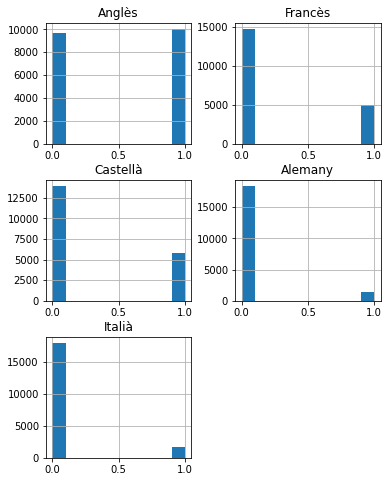

In [ ]:
fig = plt.figure(figsize = (6,8))
ax = fig.gca()
dd.hist(['Anglès','Francès','Castellà','Alemany','Italià'], ax = ax);

En últim lloc, s'analitza la variable uni_catala_ultim_any. Aquesta és escrita a mà pels estudiants que realitzen la inscripció, raó per la qual múltiples cadenes de caràcters poden referir-se a la mateixa universitat. Així doncs, a continuació es du a terme un procés bàsic d'uniformització de la variable detectant el major nombre de relacions possible tot i que no s'assegura en cap moment que totes elles es trobin uniformitzades a causa de la gran quantitat de possibilitats.

In [ ]:
#Canviem a nan un valor totalment incorrecte que pren la variable
dd.loc[dd['uni_catala_ultim_any']==1984, 'uni_catala_ultim_any'] = np.nan

unis = pd.unique(dd['uni_catala_ultim_any'])
print(len(unis))

#Les passem totes a majúscules per a detectar parelles
dd['uni_catala_ultim_any'] = dd['uni_catala_ultim_any'].str.upper()
unis = pd.unique(dd['uni_catala_ultim_any'])
print(len(unis))

1558
1379


In [ ]:
unis = unis.tolist()
unis.remove(np.nan) #Eliminem el nan

unis_iguals = []
for x in unis:
  similar = difflib.get_close_matches(x, unis, cutoff=0.91)
  if len(similar) > 1: #té alguna parella a part d'ella mateixa
    for y in similar:
      dd.loc[dd['uni_catala_ultim_any'] == y, 'uni_catala_ultim_any'] = x
      #unis_iguals.append([x,":", y])
      unis.remove(y)
#unis_iguals

In [ ]:
unis = pd.unique(dd['uni_catala_ultim_any'])
print(len(unis))

1036


In [ ]:
unisACanviar = [["AIX|MARS",'AIX-MARSEILLE UNIVERSITÉ'],['MONTPELLIER','UNIVERSITÉ PAUL-VALÉRY MONTPELLIER III'], ['ZADAR', 'UNIVERSITAT DE ZADAR'],
                ['HERRIKO|UPV|BASC|VASCO','EUSKAL HERRIKO UNIBERTSITATEA', 'UNIVERSITAT DEL PAÍS BASC'], ['ILLINOIS','UNIVERSITAT DE ILLINOIS (URBANA-CHAMPAIGN)'],
                ['KONSTANZ','UNIVERSITAT KONSTANZ'], ['TRENTO','UNIVERSITÀ DEGLI STUDI DI TRENTO'], ['TOULOUSE|JAUR','UNIVERSITÉ TOULOUSE II JEAN JAURÈS - MIRAIL'],
                ['HAVANA|HABANA', "UNIVERSITAT DE L'HAVANA"], ['CAMBRIDGE', 'CAMBRIDGE UNIVERSITY'], ['BOLO', 'UNIVERSITÀ DI BOLOGNA'], ['MASAR', 'UNIVERSITAT MASARYK BRNO'], 
                ['COMPOSTEL|USC|U.S.C','UNIVERSIDADE DE SANTIAGO DE COMPOSTELA'], ['CHILE|XILE', 'PONTIFICIA UNIVERSITAT CATÓLICA DE XILE'],
                ['PETERSBURG|SPBGU', 'SAINT-PETERSBURG STATE UNIVERSITY'], ['SHEFFIELD','UNIVERSITY OF SHEFFIELD'], ['ALACANT','UNIVERSITAT ALACANT'],
                ['HERNANDEZ|UMH','UNIVERSIDAD MIGUEL HERNANDEZ'], ['LEEDS', 'UNIVERSITY OF LEEDS'], ['CARDIFF','UNIVERSITAT DE CARDIFF'],
                ['FOSCARI',"UNIVERSITÀ CA' FOSCARI DI VENEZIA"], ['EDINBURGH|EDIMBURG','UNIVERSITY OF EDINBURGH'], ['LEIPZIG', 'UNIVERSITAT DE LEIPZIG'],
                ['TORINO|TORÍ|TORÌ|DE TURI', 'UNIVERSITÀ DEGLI STUDI DI TORINO'], ['NANTES', 'UNIVERSITÉ DE NANTES'], ['MAYN', 'MAYNOOTH UNIVERSITY'],
                ['UNAM|MÉXICO','UNIVERSIDAD NACIONAL AUTÓNOMA DE MEXICO (UNAM)'], ['HEBRE','HEBREW UNIVERSITY'], ['QUEEN','QUEEN MARY, UNIVERSITY OF LONDON'],
                ['HUMBOLDT','HUMBOLDT UNIVERSITÄT'], ['RUHR|BOCHUM','RUHR-UNIVERSITÄT BOCHUM'], ['BARI|ALDO',"UNIVERSITA' DEGLI STUDI DI BARI ALDO MORO"],
                ['MSTERDAM', 'UNIVERSITY OF AMSTERDAM'], ['BELGRAD|FILOLOGIA','UNIVERSITAT DE LA FILOLOGIA DE BELGRAD'], ['USAL|SALAMANCA','UNIVERSIDAD DE SALAMANCA (USAL)'],
                ['LISBOA', 'UNIVERSIDADE DE LETRAS DE LISBOA'], ['BRISTOL', 'UNIVERSITY OF BRISTOL'],['COLUMBIA', 'UNIVERSITAT DE COLUMBIA'], ['BUC','UNIVERSITATEA BUCURESTI'],
                ['DURHAM','UNIVERSITY OF DURHAM'], ['NEWCASTLE','NEWCASTLE UNIVERSITY'], ['ELTE|EÖTVÖS|EOTVOS','EÖTVÖS LORÁND TUDOMÁNYEGYETEM (ELTE)'], ['LA SAPIENZA', 'UNIVERSITÀ DEGLI STUDI DI ROMA "LA SAPIENZA"'],
                ['BEOGRAD|BEGRAD|FACULTY OF PHILOLOGY|FILOLOSKI FAKULTET','UNIVERSITAT DE LA FILOLOGIA DE BELGRAD'], ['JAGIELLO','UNIVERSITAT JAGELLÒNICA DE CRACÒVIA'], ['SIENA','UNIVERSITAT PER ESTRANGERS DE SIENA'],
                ['ADAM M|ADAMA M|POZNA','UNIVERSISTAT DE ADAM MICKIEWICZ POZNA']]

In [ ]:
for i in range(len(unisACanviar)):
  dd.loc[dd["uni_catala_ultim_any"].str.contains(unisACanviar[i][0], case=False, na=True), 'uni_catala_ultim_any'] = unisACanviar[i][1] #case = Flase --> no sensitiu a majúscules i minúscules 
  

In [ ]:
unis = pd.unique(dd['uni_catala_ultim_any'])
print(len(unis))

663


In [ ]:
#S'elimina algun valor que se sap que és totalment incorrecte
dd.loc[dd['uni_catala_ultim_any']=='UNIVERSITAT', 'uni_catala_ultim_any'] = np.nan
dd.loc[dd['uni_catala_ultim_any']=='A LA UNIVERSITAT', 'uni_catala_ultim_any'] = np.nan
dd.loc[dd['uni_catala_ultim_any']=='A LA UNIVERSITAT.', 'uni_catala_ultim_any'] = np.nan
dd.loc[dd['uni_catala_ultim_any']=='A LA MEVA UNIVERSITAT', 'uni_catala_ultim_any'] = np.nan
dd.loc[dd['uni_catala_ultim_any']=="A L'ESCOLA", 'uni_catala_ultim_any'] = np.nan
dd.loc[dd['uni_catala_ultim_any']=='EN L´ESCOLA', 'uni_catala_ultim_any'] = np.nan
dd.loc[dd['uni_catala_ultim_any']=='NO HE CURSAT CATALÀ', 'uni_catala_ultim_any'] = np.nan

### Pas 4: Comprovar la correctesa dels nombres

Per a comprovar que les columnes que contenen números són correctes es realitzaran 3 tipus de mètodes. 

Per a les variables categòriques s'utilitzaran histogrames, per als IDs seqüencials, s'usarà simples gràfics de punts per a comprovar que la seqüència és contínua i per a les variables de tipus quantitatiu, com els imports, es començarà utilitzant boxplots, per a comprovar que cap nombre es troba fora del comú i s'acabarà utilitzant altres tècniques si les dades així ho requereixen.

In [ ]:
categorics = ['informe_avaluacio','num_clausus_nivell','certificat_mobilitat_creat', 'presentat',
              'resultat', 'canvi_pendent', 'id_nivell', 'actiu_conv_seus_nivells',
              'format_electronic_conv_seus', 'enregistradora_conv_seus','codi_convocatoria', 'any_convocatoria',
              'actiu_convocatoria', 'pagament_transferencia_actiu_convocatoria',
              'descarrega_proves_activa_convocatoria', 'certificat_mobilitat_actiu_convocatoria','codi_seus',
              'gratuita_seus', 'ambit_alumne']
ids = ['id_examen', 'sequencial_conv_seus_nivells', 'id_conv_seus','id_convocatoria','id_seus','id_pais',
       'num_pais','id_alumnes', 'id_pais_alumnes', 'num_pais_alumne', 'id_conv_seus_nivells']
quant = ['irpf1_pais_alumne', 'irpf2_pais_alumne', 'preu','preu_conv_seus_nivells', 'import_pagat',
         'preu_nivell', 'irpf1_pais', 'irpf2_pais']

En primer lloc s'analitzen les variables categòriques:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


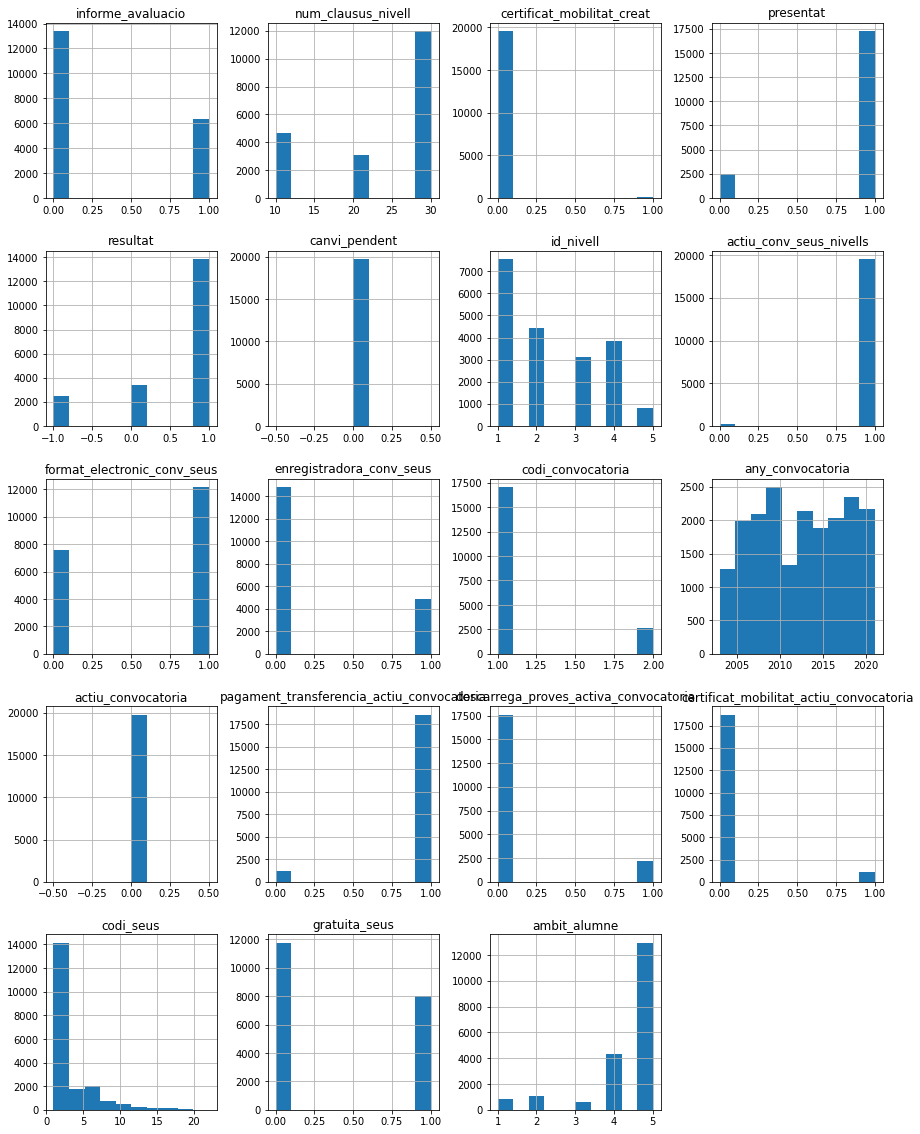

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
dd.hist(categorics, ax = ax);

Es nota que les variables canvi_pendent i actiu_convocatoria només prenen el valor 0 sent doncs informació no útil que per tant s'elimina del conjunt de dades

In [ ]:
dd = dd.drop(columns = ['canvi_pendent', 'actiu_convocatoria'])

A continuació s'analitzen els IDs:

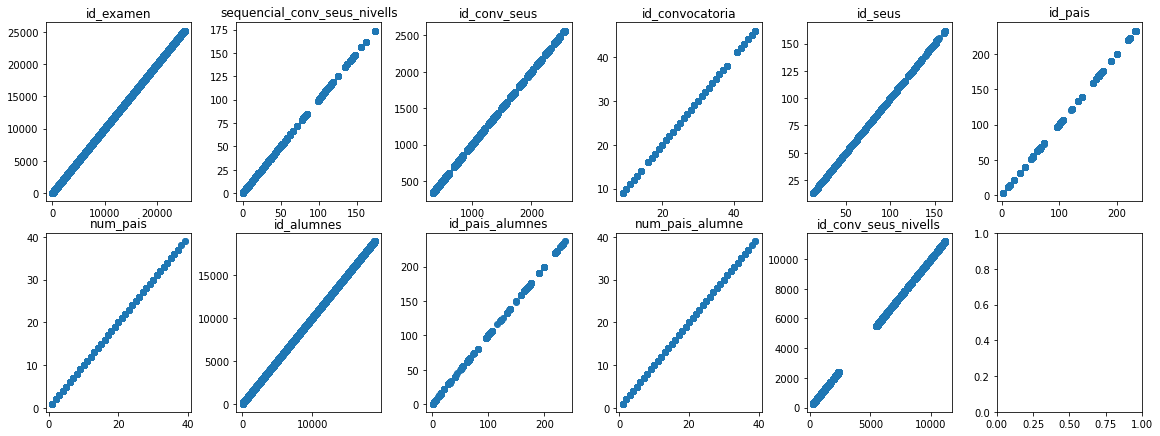

In [ ]:
fig, axs = plt.subplots(2, 6)
fig.set_figheight(6)
fig.set_figwidth(16)
fig.tight_layout()
aux = [0,0,0,0,0,0,1,1,1,1,1,1]
for i in range(0,len(ids)):
  axs[aux[i], np.mod(i,6)].plot(dd[ids[i]],dd[ids[i]], 'o')
  axs[aux[i], np.mod(i,6)].set_title(ids[i])

El salt altament visible a la variable id_conv_seus_nivells sembla extrany. Tanmateix, s'analitza i s'arriba a la conclusió que la variable és correcte

Finalment s'analitzen les variables quantitatives

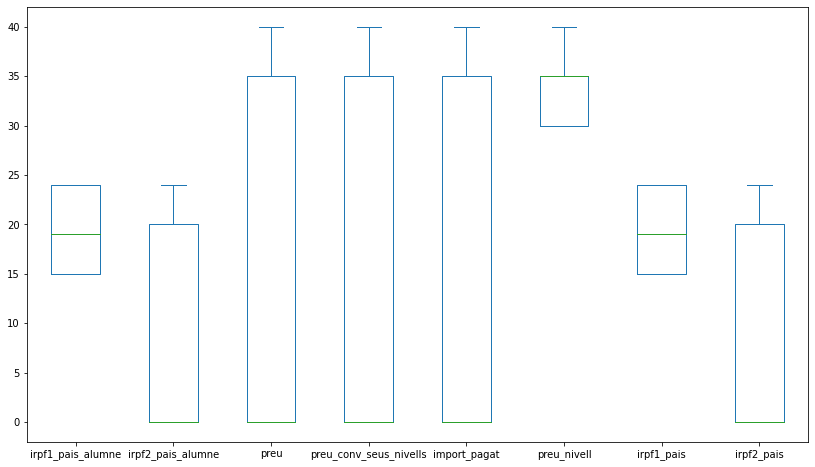

In [ ]:
dd[quant].plot.box(figsize=(14,8));

Cap valor es troba fora dels rangs interquartílics i per tant es considera tot correcte

### Pas 5: Validar la correctesa de les dades en funció de la seva naturalesa

La majoria de restriccions que les dades han de complir ja s'han comprovat de manera intrínseca mentre s'analitzaven els valors que aquestes prenien i, per tant, només falta comprovar que els països amb taxes no exemptes de pagaments prenguin algun 0 per a la variable preu.

En concret se sap que els exàmens de nivell bàsic valen 30 €, els de nivell elemental i intermedi 35 € i finalment els dos nivells superiors 40 €. A continuació doncs s'assegurarà que tots els exàmens que s'hagin realitzat en algunes de les localitats no exemptes de pagament tinguin la variable preu correctament informada en funció d'aquesta normativa.

In [ ]:
paisos_paguen = "França|Estats Units d'Amèrica|Països Baixos|Alemanya|Regne Unit|Itàlia|BèlgicaIrlanda|Suïssa|Espanya|Israel|Luxemburg|Austràlia|Canadà|Equador|Xile|Corea, República de|Japó|Portugal|Finlàndia"
dd.loc[(dd["nivell"]=="Bàsic") & (dd["pais"].str.contains(paisos_paguen, case=False)), 'preu'] = 30
dd.loc[(dd["nivell"].str.contains("Elemental|Intermedi", case=False)) & (dd["pais"].str.contains(paisos_paguen, case=False)), 'preu'] = 35
dd.loc[(dd["nivell"].str.contains("Suficiència|Superior", case=False)) & (dd["pais"].str.contains(paisos_paguen, case=False)), 'preu'] = 40

### Pas 6: Construcció o recodificació de les variables per a realitzar els gràfics

Tot seguit es recodificaran o es crearan noves variables amb l'objectiu de poder realitzar els gràfics de forma més senzilla.

1.  Per tal de saber si com més dies es troba oberta una convocatòria, més alumnes s'apunten a aquesta, es codifica una nova variable que contingui el nombre de dies d'obertura per a posteriorment poder realitzar amb major facilitat el gràfic

In [ ]:
dd['dies_inscripcio_convocatoria'] = (dd['data_tancament_inscripcio_convocatoria'] - dd['data_obertura_inscripcio_convocatoria']).dt.days

2.  A continuació es calcula l'edat que tenen els alumnes per a poder-la analitzar:

In [ ]:
avui = datetime.datetime.now()
dd['edat_alumnes'] = np.round(((avui - dd['data_naixement_alumne']).dt.days)/365, 0)

3.  Tot seguit, tot i que no seria estrictament necessari, per tal que els gràfics quedin més entenedors i el codi sigui el més fàcil possible es recodificaran les variables que indiquen els nivells d'estudis i el motiu per a realitzar les proves

In [ ]:
dd.loc[dd['nivell_estudis_alumne'] == 'SU', 'nivell_estudis_alumne'] = "Superiors"
dd.loc[dd['nivell_estudis_alumne'] == 'TE', 'nivell_estudis_alumne'] = "Tècnics"
dd.loc[dd['nivell_estudis_alumne'] == 'SE', 'nivell_estudis_alumne'] = "Secundaris"
dd.loc[dd['nivell_estudis_alumne'] == 'PR', 'nivell_estudis_alumne'] = "Primaris"
dd.loc[dd['motiu_prova_alumne'] == 'ES', 'motiu_prova_alumne'] = "Estudis de lingüística o filologia"
dd.loc[dd['motiu_prova_alumne'] == 'IN', 'motiu_prova_alumne'] = "Interès personal"
dd.loc[dd['motiu_prova_alumne'] == 'LA', 'motiu_prova_alumne'] = "Laboral"
dd.loc[dd['motiu_prova_alumne'] == 'AL', 'motiu_prova_alumne'] = "Altres"

4.  Posteriorment, es realitza el mateix proccés però en aquest cas amb les variables resultat i ambit_alumne per a comprendre millor les seves categories

In [ ]:
dd.loc[dd['resultat']==-1, 'resultat'] = "No presentat"
dd.loc[dd['resultat']==1, 'resultat'] = "Apte"
dd.loc[dd['resultat']==0, 'resultat'] = "No apte"
dd.loc[dd['ambit_alumne']==1, 'ambit_alumne'] = "Catalunya"
dd.loc[dd['ambit_alumne']==2, 'ambit_alumne'] = "Balears"
dd.loc[dd['ambit_alumne']==3, 'ambit_alumne'] = "País Valencià"
dd.loc[dd['ambit_alumne']==4, 'ambit_alumne'] = "Resta de l'estat espanyol"
dd.loc[dd['ambit_alumne']==5, 'ambit_alumne'] = "Resta del món"

5.  Es realitza una nova recodificació d'una variable en aquest cas per afegir informació a les categories

In [ ]:
dd.loc[dd['nivell']=="Bàsic", 'nivell'] = "Bàsic (A2)"
dd.loc[dd['nivell']=="Elemental", 'nivell'] = "Elemental (B1)"
dd.loc[dd['nivell']=="Intermedi", 'nivell'] = "Intermedi (B2)"
dd.loc[dd['nivell']=="Suficiència", 'nivell'] = "Suficiència (C1)"
dd.loc[dd['nivell']=="Superior", 'nivell'] = "Superior (C2)"

6.  En penúltim lloc s'eliminaran alguns països dels estudiants perquè no es vol que aquests surtin a les gràfiques. Aquesta recodificació ha estat demanada pels usuaris interns de l'àrea de llengua i universitats

In [ ]:
dd.loc[dd['pais_alumne']=="Afganistan", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Andorra", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Anguilla (Regne Unit)", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Armènia", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Aràbia Saudita", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Austràlia", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Bouvet, illa (Noruega)", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Christmas, illa", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=='Corea, República Democràtica Popular de', 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Corea, República de", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Costa Rica", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Colòmbia", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Grècia", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Jamaica", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Letònia", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Lituània", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Malàisia", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Mauritània", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Montenegro", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Nepal", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Nicaragua", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Verges, illes (Regne Unit) ", 'pais_alumne'] = np.nan
dd.loc[dd['pais_alumne']=="Bòsnia i Hercegovina", 'pais_alumne'] = np.nan

7.  Finalment, es crea una nova variable anomenada nivell_pais_hcat que codificarà el nivell més comú donat un país i unes hores de català per a poder realitzar el gràfic: "Nivell obtingut en funció del país de naixement i les hores de català estudiades"

In [ ]:
pais_naix = pd.unique(dd['pais_alumne'])
hores_cat = pd.unique(dd['hores_catala_alumne'])

dd['nivell_pais_hcat'] = np.nan

for x in pais_naix:
  for y in hores_cat:
    filter = (dd['pais_alumne'] == x) & (dd['hores_catala_alumne'] == y) 
    if sum(filter) > 0: #ens assegurem que existeixi alguna tuple amb aquestes dues categories
      nivell = dd.loc[filter, 'nivell'].value_counts().idxmax() #busquem el nivell més repetit
      dd.loc[filter, 'nivell_pais_hcat'] = nivell 

### Es guarden les dades amb què es treballarà

Un cop realitzats tots els canvis necessaris sobre el conjunt de dades, es guarden les dades amb què es treballarà a partir d'ara en un nou fitxer per no haver de fer cada cop tot el tractament de dades.

In [ ]:
dd.head()

,id_examen,informe_avaluacio,certificat_mobilitat_creat,preu,import_pagat,data_pagament,presentat,resultat,id_conv_seus_nivells,actiu_conv_seus_nivells,...,tipus_institucio,llengua_materna_alumnes,Anglès,Francès,Castellà,Alemany,Italià,dies_inscripcio_convocatoria,edat_alumnes,nivell_pais_hcat
0,3070,0,0,30,30,2011-03-20 12:11:47,1,Apte,1060,1,...,UNIVERSITAT,NaN,0,0,0,0,0,43,31.0,NaN
1,3466,0,0,30,30,2011-04-06 19:10:31,1,Apte,1060,1,...,UNIVERSITAT,Francès,0,0,0,0,0,43,31.0,NaN
2,4130,0,0,30,30,2011-04-28 11:08:12,1,Apte,1060,1,...,UNIVERSITAT,Francès,1,0,1,0,0,43,53.0,NaN
3,10657,0,0,30,0,NaT,1,Apte,5478,1,...,UNIVERSITAT,Francès,0,0,1,0,0,48,35.0,NaN
4,10723,0,0,30,0,NaT,1,Apte,5478,1,...,UNIVERSITAT,Francès,0,0,0,0,0,48,36.0,Bàsic (A2)


In [ ]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19749 entries, 0 to 19761
Data columns (total 71 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id_examen                                     19749 non-null  int64         
 1   informe_avaluacio                             19749 non-null  int64         
 2   certificat_mobilitat_creat                    19749 non-null  int64         
 3   preu                                          19749 non-null  int64         
 4   import_pagat                                  19749 non-null  int64         
 5   data_pagament                                 8815 non-null   datetime64[ns]
 6   presentat                                     19749 non-null  int64         
 7   resultat                                      19749 non-null  object        
 8   id_conv_seus_nivells                          19749 non-null  int6

In [ ]:
dd.to_excel('certificacio_final.xlsx', index=False)